<a href="https://colab.research.google.com/github/akrocq/NHL-Goalie-Pulltime-Calculator/blob/main/MSCI_431.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSCI 431 Notebook for Data Analytics / Extraction

There are four parts to this notebook.

# 1. Probability Extraction
Leveraging the NHL Statistics API, we are able to extract data for NHL games throughout the 2021 season. This data includes live data relating to shots, goals, player information, and more. Leveraging this data, we are able to calculate the Markov Chain probabilities from empirical data to effectively refine the model.


# 2. Empirical Data for Pulling the Goalie Success
Utilizing the Chords Analytics provided dataset, we are able to find the success and failures rates of pulling the goalie. This was especially useful to compute the average time remaining of when a goalie pull was successful or resulted in failure which was utilized in the testing of conducted studies.



# 3. Coach Markov Pulls Goalie Poisson Testing
Utilizing the Coach MArkov Pulls Goalie Markov model, we backtest it in the case of Team A, the team defending the lead, scoring a goal from initially being in a neutral zone. We find the model's projected, optimal time remaining to pull the goalie to reach the state of Team A scoring. This is to find the optimal time, t, in order to compare the model's predicted time with the empirical data collected in Part 2.


# 4. Testing our Model (Markov Momentum)
Utilizing the probabilities gathered in the Markov Momentum model, we test and compute the optimal time remaining for different scenarios.

In [ ]:
import requests
import pandas as pd
import numpy as np
import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

## Extracting Single, Double, and Triple Shot Probabilities for the **Even Strength** Scenario

Assuming that all events happen within the third period with a minimum of three minutes remaining.

In [ ]:
def clean_even_strength_df(df):
  df.drop('players', axis=1, inplace=True)
  print("Cleaning up results...")
  df = pd.concat([df.drop('result', axis=1), df['result'].apply(pd.Series)], axis=1)
  print("Cleaning up about...")
  df = pd.concat([df.drop('about', axis=1), df['about'].apply(pd.Series)], axis=1)
  df = pd.concat([df.drop('coordinates', axis=1), df['coordinates'].apply(pd.Series)], axis=1)
  print("Cleaning up team information...")
  df = pd.concat([df.drop('team', axis=1), df['team'].apply(pd.Series)], axis=1)
  df.drop(['ordinalNum', 'id', 'link', 'triCode', 0], axis=1, inplace=True)
  df.rename(columns={'name': 'teamName'}, inplace=True)
  print("Cleaning up strength & goals...")
  df = pd.concat([df.drop('strength', axis=1), df['strength'].apply(pd.Series)], axis=1)
  df = pd.concat([df.drop('goals', axis=1), df['goals'].apply(pd.Series)], axis=1)
  df.rename(columns={'name': 'strength', 'home': 'home_goals', 'away':'away_goals'}, inplace=True)
  df.drop([0, 'code'], axis=1, inplace=True)
  df = df[df['period'] == 3]
  print('Finishing....')
  df['period_minutes_remaining'] = df.periodTimeRemaining.apply(lambda x: int(x.split(':')[0]))
  df['period_seconds_remaining'] = df.periodTimeRemaining.apply(lambda x: int(x.split(':')[1]))
  df = df[df['period_minutes_remaining'] <= 9]
  print("Finshed.")
  return df

In [ ]:
def get_event_df(year):
  API_URL = "https://statsapi.web.nhl.com/api/v1"

  start_num = int(f'{year}020001')
  goal_data=[]

  for i in range(start_num, start_num + 1272):

    response = requests.get(API_URL + f"/game/{i}/feed/live", params={"Content-Type": "application/json"})
    data = response.json()
    for j in range(len(data['liveData']['plays']['allPlays'])):
      current_event = data['liveData']['plays']['allPlays'][j]['result']['event']
      if ('Shot' in current_event) or ('Goal' in current_event):
        eventInfo = data['liveData']['plays']['allPlays'][j]
        eventInfo.update({'gameID': i})
        goal_data.append(eventInfo)
  return clean_even_strength_df(pd.DataFrame(goal_data))

In [ ]:
# Getting all event data from 2021
df = get_event_df(2021)

Cleaning up results...
Cleaning up about...
Cleaning up team information...
Cleaning up strength & goals...
Finishing....
Finshed.


In [ ]:
def get_average_time_between_events(df):

  shotMappings = {'BLOCKED_SHOT': 'SHOT', 'MISSED_SHOT': 'SHOT', 'SHOT': 'SHOT', 'GOAL': 'GOAL', 'EMERGENCY_GOALTENDER': 'SHOT'}
  df['eventTypeId'] = df['eventTypeId'].map(shotMappings)
  event_total = 0
  event_seconds = 0
  df['total_seconds_remaining'] = df['period_minutes_remaining']*60 + df['period_seconds_remaining']
  for n in df.gameID.unique():
    temp = df[df['gameID'] == n]
    try:
      temp['nextEvent'] = temp['eventTypeId'].shift(-1)
      temp['next_event_seconds_remainining'] = temp['total_seconds_remaining'].shift(-1)
      temp.dropna(subset=['nextEvent', 'next_event_seconds_remainining'], inplace=True)
      for index, row in temp.iterrows():
        event_seconds = (row['total_seconds_remaining'] - row['next_event_seconds_remainining']) + event_seconds
        event_total = event_total + 1
    except:
      continue

  return event_seconds/event_total

In [ ]:
get_average_time_between_events(df)

31.39426900050272

This is what the data looks like for our calculations:

In [ ]:
df.head()

,gameID,event,eventCode,eventTypeId,description,secondaryType,gameWinningGoal,emptyNet,eventIdx,eventId,...,dateTime,x,y,teamName,strength,away_goals,home_goals,period_minutes_remaining,period_seconds_remaining,total_seconds_remaining
89,2021020001,Missed Shot,TBL500,SHOT,Drew O'Connor Wide of Net Andrei Vasilevskiy,NaN,NaN,NaN,268,500,...,2021-10-13T01:50:54Z,-61.0,14.0,Pittsburgh Penguins,NaN,2,0,9,49,589
90,2021020001,Missed Shot,TBL492,SHOT,John Marino Over Net Andrei Vasilevskiy,NaN,NaN,NaN,269,492,...,2021-10-13T01:50:57Z,-61.0,-9.0,Pittsburgh Penguins,NaN,2,0,9,46,586
91,2021020001,Blocked Shot,TBL493,SHOT,John Marino shot blocked shot by Alex Killorn,NaN,NaN,NaN,270,493,...,2021-10-13T01:51:05Z,-80.0,3.0,Tampa Bay Lightning,NaN,2,0,9,38,578
92,2021020001,Shot,TBL495,SHOT,Jason Zucker Wrist Shot saved by Andrei Vasile...,Wrist Shot,NaN,NaN,273,495,...,2021-10-13T01:52:07Z,-73.0,-14.0,Pittsburgh Penguins,NaN,2,0,9,12,552
93,2021020001,Goal,TBL496,GOAL,"Dominik Simon (1) Wrist Shot, assists: Kris Le...",Wrist Shot,True,False,274,496,...,2021-10-13T01:52:51Z,-52.0,29.0,Pittsburgh Penguins,Even,3,0,8,28,508


In [ ]:
def get_probability_single_shot(df):

  shotMappings = {'BLOCKED_SHOT': 'SHOT', 'MISSED_SHOT': 'SHOT', 'SHOT': 'SHOT', 'GOAL': 'GOAL', 'EMERGENCY_GOALTENDER': 'SHOT'}
  df['eventTypeId'] = df['eventTypeId'].map(shotMappings)
  probs = dict(
      sameTeamShot = 0,
      sameTeamGoal = 0,
      diffTeamShot = 0,
      diffTeamGoal = 0,
  )
  total = 0
  for n in df.gameID.unique():
    temp = df[df['gameID'] == n]
    teams = temp.teamName.unique()
    try:
      A, B = teams[0], teams[1]
      temp['teamA'] = A
      temp['teamB'] = B
      temp.rename(columns={'teamName':'eventTeam'}, inplace=True)
      temp['nextEvent'] = temp['eventTypeId'].shift(-1)
      temp['nextTeam'] = temp['eventTeam'].shift(-1)
      temp.dropna(subset=['nextEvent', 'nextTeam'], inplace=True)
      for index, row in temp.iterrows():
        if (row['eventTypeId'] == 'SHOT') and ((row['eventTeam'] == A)):
          total = total + 1
          if row['nextTeam'] == A:
            if row['nextEvent'] == 'SHOT':
              probs['sameTeamShot'] = probs['sameTeamShot'] + 1
            elif row['nextEvent'] == 'GOAL':
              probs['sameTeamGoal'] = probs['sameTeamGoal'] + 1
          elif row['nextTeam'] == B:
            if row['nextEvent'] == 'SHOT':
              probs['diffTeamShot'] = probs['diffTeamShot'] + 1
            elif row['nextEvent'] == 'GOAL':
              probs['diffTeamGoal'] = probs['diffTeamGoal'] + 1
    except:
      continue

  for val in probs.keys():
    probs[val] = probs[val] / total
  return probs

In [ ]:
get_probability_single_shot(df)

{'sameTeamShot': 0.4989542602527962,
 'sameTeamGoal': 0.03619168864235701,
 'diffTeamShot': 0.4316631808675093,
 'diffTeamGoal': 0.03319087023733745}

In [ ]:
def get_probability_double_shot(df):

  shotMappings = {'BLOCKED_SHOT': 'SHOT', 'MISSED_SHOT': 'SHOT', 'SHOT': 'SHOT', 'GOAL': 'GOAL', 'EMERGENCY_GOALTENDER': 'SHOT'}
  df['eventTypeId'] = df['eventTypeId'].map(shotMappings)
  probs = dict(
      sameTeamShot = 0,
      sameTeamGoal = 0,
      diffTeamShot = 0,
      diffTeamGoal = 0,
  )
  total = 0
  for n in df.gameID.unique():
    temp = df[df['gameID'] == n]
    teams = temp.teamName.unique()
    try:
      A, B = teams[0], teams[1]
      temp['teamA'] = A
      temp['teamB'] = B
      temp.rename(columns={'teamName':'eventTeam'}, inplace=True)
      temp['nextEvent'] = temp['eventTypeId'].shift(-1)
      temp['nextTeam'] = temp['eventTeam'].shift(-1)
      temp['nextnextEvent'] = temp['eventTypeId'].shift(-2)
      temp['nextnextTeam'] = temp['eventTeam'].shift(-2)
      temp.dropna(subset=['nextEvent', 'nextTeam', 'nextnextEvent', 'nextnextTeam'], inplace=True)
      for index, row in temp.iterrows():
        if (row['eventTypeId'] == 'SHOT') and (row['eventTeam'] == A) and (row['nextEvent'] == 'SHOT') and (row['nextTeam'] == A):
          total = total + 1
          if row['nextnextTeam'] == A:
            if row['nextnextEvent'] == 'SHOT':
              probs['sameTeamShot'] = probs['sameTeamShot'] + 1
            elif row['nextnextEvent'] == 'GOAL':
              probs['sameTeamGoal'] = probs['sameTeamGoal'] + 1
          elif row['nextnextTeam'] == B:
            if row['nextnextEvent'] == 'SHOT':
              probs['diffTeamShot'] = probs['diffTeamShot'] + 1
            elif row['nextnextEvent'] == 'GOAL':
              probs['diffTeamGoal'] = probs['diffTeamGoal'] + 1
    except:
      continue

  for val in probs.keys():
    probs[val] = probs[val] / total
  return probs

In [ ]:
get_probability_double_shot(df)

{'sameTeamShot': 0.5090038314176245,
 'sameTeamGoal': 0.03773946360153257,
 'diffTeamShot': 0.41954022988505746,
 'diffTeamGoal': 0.03371647509578544}

In [ ]:
def get_probability_triple_shot(df):

  shotMappings = {'BLOCKED_SHOT': 'SHOT', 'MISSED_SHOT': 'SHOT', 'SHOT': 'SHOT', 'GOAL': 'GOAL', 'EMERGENCY_GOALTENDER': 'SHOT'}
  df['eventTypeId'] = df['eventTypeId'].map(shotMappings)
  probs = dict(
      sameTeamShot = 0,
      sameTeamGoal = 0,
      diffTeamShot = 0,
      diffTeamGoal = 0,
  )
  total = 0
  for n in df.gameID.unique():
    temp = df[df['gameID'] == n]
    teams = temp.teamName.unique()
    try:
      A, B = teams[0], teams[1]
      temp['teamA'] = A
      temp['teamB'] = B
      temp.rename(columns={'teamName':'eventTeam'}, inplace=True)
      temp['nextEvent'] = temp['eventTypeId'].shift(-1)
      temp['nextTeam'] = temp['eventTeam'].shift(-1)
      temp['nextnextEvent'] = temp['eventTypeId'].shift(-2)
      temp['nextnextTeam'] = temp['eventTeam'].shift(-2)
      temp['nextnextnextEvent'] = temp['eventTypeId'].shift(-3)
      temp['nextnextnextTeam'] = temp['eventTeam'].shift(-3)
      temp.dropna(subset=['nextEvent', 'nextTeam', 'nextnextEvent', 'nextnextTeam', 'nextnextnextEvent', 'nextnextnextTeam'], inplace=True)
      for index, row in temp.iterrows():
        if (row['eventTypeId'] == 'SHOT') and (row['eventTeam'] == A) and (row['nextEvent'] == 'SHOT') and (row['nextTeam'] == A) and (row['nextnextEvent'] == 'SHOT') and (row['nextnextTeam'] == A):
          total = total + 1
          if row['nextnextnextTeam'] == A:
            if row['nextnextnextEvent'] == 'SHOT':
              probs['sameTeamShot'] = probs['sameTeamShot'] + 1
            elif row['nextnextnextEvent'] == 'GOAL':
              probs['sameTeamGoal'] = probs['sameTeamGoal'] + 1
          elif row['nextnextnextTeam'] == B:
            if row['nextnextnextEvent'] == 'SHOT':
              probs['diffTeamShot'] = probs['diffTeamShot'] + 1
            elif row['nextnextnextEvent'] == 'GOAL':
              probs['diffTeamGoal'] = probs['diffTeamGoal'] + 1
    except:
      continue

  for val in probs.keys():
    probs[val] = probs[val] / total
  return probs

In [ ]:
get_probability_triple_shot(df)

{'sameTeamShot': 0.5170094936708861,
 'sameTeamGoal': 0.037183544303797465,
 'diffTeamShot': 0.4125791139240506,
 'diffTeamGoal': 0.03322784810126582}

Here we calculate the probability of a shot or goal happening directly after a game reaches the "Period 3, 10 minutes remaining mark."

In [ ]:
def get_next_action_probability(df):

  df = df[abs(df['away_goals'] - df['home_goals']) > 0]

  shotMappings = {'BLOCKED_SHOT': 'SHOT', 'MISSED_SHOT': 'SHOT', 'SHOT': 'SHOT', 'GOAL': 'GOAL', 'EMERGENCY_GOALTENDER': 'SHOT'}
  df['eventTypeId'] = df['eventTypeId'].map(shotMappings)
  probs = dict(
      shotA = 0,
      goalA = 0,
  )
  total = 0
  for n in df.gameID.unique():
    temp = df[df['gameID'] == n]
    try:
      temp.rename(columns={'teamName':'eventTeam'}, inplace=True)
      total = total + 1
      action = temp['eventTypeId'].iloc[0]
      if action == 'SHOT':
        probs['shotA'] = probs['shotA'] + 1
      elif action == 'GOAL':
        probs['goalA'] = probs['goalA'] + 1
    except:
      continue

  for val in probs.keys():
    probs[val] = probs[val] / total / 2
  probs['shotB'] = probs['shotA']
  probs['goalB'] = probs['goalA']
  return probs

In [ ]:
get_next_action_probability(df)

{'shotA': 0.4193965517241379,
 'goalA': 0.08060344827586206,
 'shotB': 0.4193965517241379,
 'goalB': 0.08060344827586206}

## Extracting Single, Double, and Triple Shot Probabilities for the **Empty Net** Scenario

Assuming that all events happen within the third period with a minimum of three minutes remaining.

In [ ]:
def clean_empty_net_df(df):
  df.drop('players', axis=1, inplace=True)
  print("Cleaning up results...")
  df = pd.concat([df.drop('result', axis=1), df['result'].apply(pd.Series)], axis=1)
  print("Cleaning up about...")
  df = pd.concat([df.drop('about', axis=1), df['about'].apply(pd.Series)], axis=1)
  df = pd.concat([df.drop('coordinates', axis=1), df['coordinates'].apply(pd.Series)], axis=1)
  print("Cleaning up team information...")
  df = pd.concat([df.drop('team', axis=1), df['team'].apply(pd.Series)], axis=1)
  df.drop(['ordinalNum', 'id', 'link', 'triCode'], axis=1, inplace=True)
  df.rename(columns={'name': 'teamName'}, inplace=True)
  print("Finshing...")
  df = pd.concat([df.drop('strength', axis=1), df['strength'].apply(pd.Series)], axis=1)
  df = pd.concat([df.drop('goals', axis=1), df['goals'].apply(pd.Series)], axis=1)
  df.rename(columns={'name': 'strength', 'home': 'home_goals', 'away':'away_goals'}, inplace=True)
  df.drop([0, 'code'], axis=1, inplace=True)
  print("Finshed.")
  return df

In [ ]:
def get_empty_net_df(year):
  API_URL = "https://statsapi.web.nhl.com/api/v1"

  start_num = int(f'{year}020001')
  goal_data=[]
  flag = None

  for i in range(start_num, start_num + 1272):

    response = requests.get(API_URL + f"/game/{i}/feed/live", params={"Content-Type": "application/json"})
    data = response.json()

    for player in data['liveData']['boxscore']['teams']['home']['players']:
      if data['liveData']['boxscore']['teams']['home']['players'][player]['position']['name'] == 'Goalie':
        time_on_ice = (data['liveData']['boxscore']['teams']['home']['players'][player]['stats']['goalieStats']['timeOnIce'])
        time_on_ice_min = time_on_ice.split(':')[0]
        time_on_ice_sec = time_on_ice.split(':')[1]
        time_on_ice = float(f'{time_on_ice_min}.{time_on_ice_sec}')
        try:
          if time_on_ice < 41 and time_on_ice_min > 59.5:
            flag = True
            continue
          if time_on_ice < 21 and time_on_ice_min > 39.5:
            flag = True
            continue
          if time_on_ice < 1 and time_on_ice_min > 19.5:
            flag = True
            continue
        except:
          flag = True
          continue
    if flag:
      continue
    for j in range(len(data['liveData']['plays']['allPlays'])):
      current_event = data['liveData']['plays']['allPlays'][j]['result']['event']
      if ('Shot' in current_event) or ('Goal' in current_event):
        eventInfo = data['liveData']['plays']['allPlays'][j]
        eventInfo.update({'gameID': i})
        goal_data.append(eventInfo)
  return clean_empty_net_df(pd.DataFrame(goal_data))

In [ ]:
df2 = get_empty_net_df(2021)
df2 = df2[df2['period'] == 3]
df2['period_minutes_remaining'] = df2.periodTimeRemaining.apply(lambda x: int(x.split(':')[0]))
df2['period_seconds_remaining'] = df2.periodTimeRemaining.apply(lambda x: int(x.split(':')[1]))
df2 = df2[df2['period_minutes_remaining'] <= 9]

Cleaning up results...
Cleaning up about...
Cleaning up team information...
Finshing...
Finshed.


This is what the data looks like for our calculations:

In [ ]:
df2.head()

,gameID,event,eventCode,eventTypeId,description,secondaryType,gameWinningGoal,emptyNet,eventIdx,eventId,...,periodTimeRemaining,dateTime,x,y,teamName,strength,away_goals,home_goals,period_minutes_remaining,period_seconds_remaining
89,2021020001,Missed Shot,TBL500,MISSED_SHOT,Drew O'Connor Wide of Net Andrei Vasilevskiy,NaN,NaN,NaN,268,500,...,09:49,2021-10-13T01:50:54Z,-61.0,14.0,Pittsburgh Penguins,NaN,2,0,9,49
90,2021020001,Missed Shot,TBL492,MISSED_SHOT,John Marino Over Net Andrei Vasilevskiy,NaN,NaN,NaN,269,492,...,09:46,2021-10-13T01:50:57Z,-61.0,-9.0,Pittsburgh Penguins,NaN,2,0,9,46
91,2021020001,Blocked Shot,TBL493,BLOCKED_SHOT,John Marino shot blocked shot by Alex Killorn,NaN,NaN,NaN,270,493,...,09:38,2021-10-13T01:51:05Z,-80.0,3.0,Tampa Bay Lightning,NaN,2,0,9,38
92,2021020001,Shot,TBL495,SHOT,Jason Zucker Wrist Shot saved by Andrei Vasile...,Wrist Shot,NaN,NaN,273,495,...,09:12,2021-10-13T01:52:07Z,-73.0,-14.0,Pittsburgh Penguins,NaN,2,0,9,12
93,2021020001,Goal,TBL496,GOAL,"Dominik Simon (1) Wrist Shot, assists: Kris Le...",Wrist Shot,True,False,274,496,...,08:28,2021-10-13T01:52:51Z,-52.0,29.0,Pittsburgh Penguins,Even,3,0,8,28


In [ ]:
get_probability_single_shot(df2)

{'sameTeamShot': 0.45993031358885017,
 'sameTeamGoal': 0.024390243902439025,
 'diffTeamShot': 0.4808362369337979,
 'diffTeamGoal': 0.03484320557491289}

In [ ]:
get_probability_double_shot(df2)

{'sameTeamShot': 0.536,
 'sameTeamGoal': 0.016,
 'diffTeamShot': 0.424,
 'diffTeamGoal': 0.024}

In [ ]:
get_probability_triple_shot(df2)

{'sameTeamShot': 0.5555555555555556,
 'sameTeamGoal': 0.015873015873015872,
 'diffTeamShot': 0.3968253968253968,
 'diffTeamGoal': 0.031746031746031744}

In [ ]:
get_next_action_probability(df2)

{'shotA': 0.46875, 'goalA': 0.03125, 'shotB': 0.46875, 'goalB': 0.03125}

## Extracting Empirical Data for Model Testing

Leveraging the Chords Analytics dataset to determine the average goalie pull times, success/failure rates, and the average of the successful goalie pull time remaining values.

To run these cells successfully, please download the CSV files from the Chords Analytics [respository]('https://github.com/chord-analytics/nhl-goalie-pull-optimization/tree/master/data/processed/csv'). Please insert the CSV files into the Google Colab 'Sample Data' folder.

In [ ]:
import pandas as pd
import os

li = []
dir = 'sample_data'
files =[]
for file in os.listdir(dir):
  if file.endswith(".csv") and 'goalie' in file:
    df = pd.read_csv(f'sample_data/{file}', index_col=None, header=0)
    li.append(df)
frame = pd.concat(li, axis=0, ignore_index=True)
df2 = frame

This what the dataset looks like, where a non-null goal_for_time or non-null goal_against_time represent successful goals for and against respectively.

In [ ]:
df2[['pull_time', 'goal_for_time', 'goal_against_time',]].head(20)

,pull_time,goal_for_time,goal_against_time
0,0 days 00:18:17.000000000,NaN,0 days 00:19:01.000000000
1,0 days 00:18:25.000000000,NaN,0 days 00:19:24.000000000
2,0 days 00:19:24.000000000,NaN,NaN
3,0 days 00:16:55.000000000,NaN,0 days 00:17:07.000000000
4,0 days 00:17:21.000000000,0 days 00:18:12.000000000,NaN
5,0 days 00:18:27.500000000,0 days 00:19:25.000000000,NaN
6,0 days 00:19:28.000000000,NaN,NaN
7,0 days 00:18:32.000000000,NaN,0 days 00:19:57.000000000
8,0 days 00:18:17.000000000,NaN,NaN
9,0 days 00:18:28.000000000,NaN,0 days 00:19:46.000000000


In [ ]:
def get_time(df, col):
  df[col] = df[col].fillna('0 days 00:00:00.000000000')

  # Extract minutes and seconds
  minutes = df[col].str.extract(r'(\d+):(\d+):(\d+)')[1].astype(int)
  seconds = df[col].str.extract(r'(\d+):(\d+):(\d+)')[2].astype(int)

  time = 1200 - minutes*60+seconds
  df[f'{col}_seconds'] = time
  return df

In [ ]:
df2 = get_time(df2, 'goal_against_time')
df2 = get_time(df2, 'goal_for_time')

In [ ]:
df2.head()

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,game_end_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta,goal_against_time_seconds,goal_for_time_seconds
0,20172018,3,CGY,2017-10-04,3,0 days 00:18:17.000000000,0 days 00:00:00.000000000,0 days 00:19:01.000000000,NaN,NaN,0 days 00:00:44.000000000,NaN,61,1200
1,20172018,4,S.J,2017-10-04,3,0 days 00:18:25.000000000,0 days 00:00:00.000000000,0 days 00:19:24.000000000,NaN,NaN,0 days 00:00:59.000000000,NaN,84,1200
2,20172018,4,S.J,2017-10-04,3,0 days 00:19:24.000000000,0 days 00:00:00.000000000,0 days 00:00:00.000000000,0 days 00:20:00.000000000,NaN,NaN,0 days 00:00:36.000000000,1200,1200
3,20172018,5,NSH,2017-10-05,3,0 days 00:16:55.000000000,0 days 00:00:00.000000000,0 days 00:17:07.000000000,NaN,NaN,0 days 00:00:12.000000000,NaN,187,1200
4,20172018,5,NSH,2017-10-05,3,0 days 00:17:21.000000000,0 days 00:18:12.000000000,0 days 00:00:00.000000000,NaN,0 days 00:00:51.000000000,NaN,NaN,1200,132


In [ ]:
df2[df2['goal_for_time'] != '0 days 00:00:00.000000000']['goal_for_time_seconds'].count()

1611

In [ ]:
df2[df2['goal_against_time'] != '0 days 00:00:00.000000000']['goal_against_time_seconds'].count()

3736

Here we calculate the mean remaining time for a goalie pull that resulted in a goal scored.

In [ ]:
df2[df2['goal_for_time'] != '0 days 00:00:00.000000000']['goal_for_time_seconds'].mean()

172.63314711359405

Here we calculate the mean remaining time for a goalie pull that resulted in a goal conceded.

In [ ]:
df2[df2['goal_against_time'] != '0 days 00:00:00.000000000']['goal_against_time_seconds'].mean()

122.7122591006424

## Finding the Optimal Time Remaining
Assuming the model generated in the Coach Markov Pulls Goalie Poisson Article, we find the optimal time remaining for when Team A scores from initially being in the neutral zone.









In [ ]:
even_strength = np.array([[1, 0, 0, 0, 0, 0, 0],
              [0.0982, 0, 0.9018, 0, 0, 0, 0],
              [0, 0.02163, 0.8872, 0.0911, 0, 0, 0],
              [0, 0, 0.131, 0.738, 0.131, 0, 0],
              [0, 0, 0, 0.0911, 0.8872, 0.02163, 0],
              [0, 0, 0, 0, 0.9018, 0, 0.0982],
              [0, 0, 0, 0, 0, 0, 1]])

val_counts_even_strength = {}
for i in range(0, 801):
  val = np.linalg.matrix_power(even_strength, i)[3][0]
  val_counts_even_strength.update({i: val})
print(val_counts_even_strength)

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.00027825264599999996, 4: 0.0007304688462792, 5: 0.0012952926608483888, 6: 0.0019327630728648154, 7: 0.002616948480613512, 8: 0.0033310194321534135, 9: 0.004064054004993267, 10: 0.004808964367283426, 11: 0.005561151080186207, 12: 0.0063176297157708046, 13: 0.0070764640162523885, 14: 0.007836398004100298, 15: 0.008596617214854276, 16: 0.009356593732910718, 17: 0.01011598561695039, 18: 0.010874571625225907, 19: 0.011632208851095935, 20: 0.012388805227723329, 21: 0.0131443016831293, 22: 0.013898660558502954, 23: 0.014651858091476719, 24: 0.015403879537638046, 25: 0.01615471600430413, 26: 0.016904362395586226, 27: 0.017652816078701044, 28: 0.018400076018384448, 29: 0.01914614221511206, 30: 0.01989101534049601, 31: 0.020634696500652576, 32: 0.021377187082625194, 33: 0.022118488654711995, 34: 0.022858602901778245, 35: 0.02359753158327469, 36: 0.02433527650599242, 37: 0.025071839506381956, 38: 0.02580722243907977, 39: 0.026541427169463488, 40: 0.027274455568821725

In [ ]:
empty_net = np.array([[1, 0, 0, 0, 0, 0, 0],
              [1, 0, 0, 0, 0, 0, 0],
              [0, 0.02163, 0.8872, 0.091, 0, 0, 0],
              [0, 0, 0.1768, 0.646, 0.1768, 0, 0],
              [0, 0, 0, 0.091, 0.742, 0.0578, 0],
              [0, 0, 0, 0, 0.9018, 0, 0.0982],
              [0, 0, 0, 0, 0, 0, 1]])

val_counts_empty_net = {}
for i in range(0, 801):
  val = np.linalg.matrix_power(empty_net, i)[3][0]
  val_counts_empty_net.update({i: val})
print(val_counts_empty_net)

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0038241840000000004, 4: 0.009687422908800002, 5: 0.016608234701909762, 6: 0.024038549495350725, 7: 0.03166975124774642, 8: 0.03932603572923997, 9: 0.04690596017223959, 10: 0.054350257712819205, 11: 0.06162401136302004, 12: 0.0687066949540001, 13: 0.0755865390230409, 14: 0.08225728670179312, 15: 0.08871628052826928, 16: 0.09496329878605164, 17: 0.10099982077715855, 18: 0.10682854306438955, 19: 0.11245304691835366, 20: 0.1178775602430292, 21: 0.12310678107724682, 22: 0.1281457430694532, 23: 0.13299971084073126, 24: 0.13767409747579445, 25: 0.1421743989303866, 26: 0.14650614169363138, 27: 0.15067484102373865, 28: 0.1546859677226263, 29: 0.1585449218623848, 30: 0.16225701219952823, 31: 0.1658274402552377, 32: 0.1692612882272028, 33: 0.17256351004705797, 34: 0.17573892501695745, 35: 0.17879221355627575, 36: 0.1817279146695177, 37: 0.18455042481270267, 38: 0.18726399789037598, 39: 0.1898727461610196, 40: 0.19238064186660805, 41: 0.19479151943368567, 42: 0.197109

In [ ]:
tolerance = 0.0001
intersect_points = []

for key in val_counts_empty_net:
    if abs(val_counts_empty_net[key] - val_counts_even_strength.get(key, 0)) < tolerance:
        intersect_points.append((key, val_counts_empty_net[key]))

In [ ]:
intersect_points

[(0, 0.0), (1, 0.0), (2, 0.0), (469, 0.2544823953822713)]

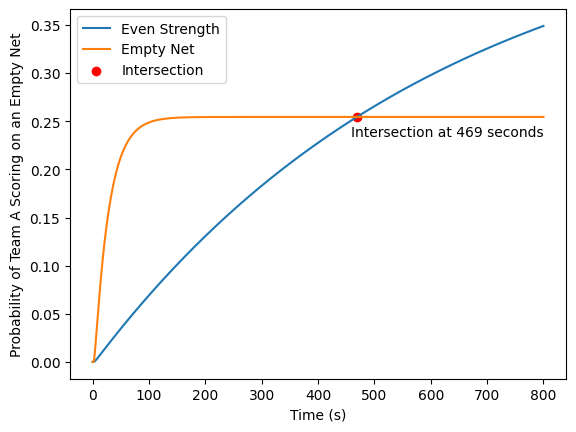

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(list(val_counts_even_strength.keys()))
y1 = np.array(list(val_counts_even_strength.values()))
y2 = np.array(list(val_counts_empty_net.values()))

plt.plot(x, y1, label='Even Strength')
plt.plot(x, y2, label='Empty Net')
plt.xlabel('Time (s)')
plt.ylabel('Probability of Team A Scoring on an Empty Net')
plt.scatter(intersect_points[3][0], intersect_points[3][1], color='red', label='Intersection')
plt.legend()

plt.text(intersect_points[3][0] - 10, intersect_points[3][1] - 0.02, 'Intersection at 469 seconds')

plt.show()

## Testing the Markov Momentum Model




## First Test

Going from Team A shooting to Team A scoring.

In [ ]:
even_strength = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
             [0.037, 0.512, 0, 0, 0, 0.413, 0, 0, 0.033],
             [0.038, 0.509, 0, 0, 0, 0.432, 0, 0, 0.034],
             [0.036, 0, 0.499, 0, 0, 0.432, 0, 0, 0.033],
             [0.08, 0, 0, 0.42, 0, 0.42, 0, 0, 0.08],
             [0.033, 0, 0, 0.432, 0, 0, 0.499, 0, 0.0036],
             [0.034, 0, 0, 0.432, 0, 0, 0, 0.509, 0.038],
             [0.033, 0, 0, 0.413, 0, 0, 0, 0.517, 0.037],
             [0, 0, 0, 0, 0, 0, 0, 0, 1]])

t = 31

val_counts_even_strength = {}
for i in range(0, 20):
 val = np.linalg.matrix_power(even_strength, i)[3][0]
 val_counts_even_strength.update({i: val})
print(val_counts_even_strength)

{0: 0.0, 1: 0.036, 2: 0.069218, 3: 0.099777187, 4: 0.12823296133099998, 5: 0.15475301467865, 6: 0.17947743615521983, 7: 0.202530093002025, 8: 0.2240244281619446, 9: 0.2440658772374106, 10: 0.2627526709476309, 11: 0.2801763791662938, 12: 0.2964223780504981, 13: 0.3115702720155414, 14: 0.32569428459285904, 15: 0.33886362232094486, 16: 0.3511428138957606, 17: 0.3625920263659565, 18: 0.37326735994887567, 19: 0.38322112291761246}


In [ ]:
empty_net = np.array([[1, 0, 0, 0, 0],
              [0.061, 0.551, 0, 0, 0.387],
              [0.050, 0.535, 0, 0, 0.4155],
              [0.0386, 0, 0.464, 0, 0.497],
              [0, 0, 0, 0, 1]])

val_counts_empty_net = {}
for i in range(0, 20):
  val = np.linalg.matrix_power(empty_net, i)[3][0]
  val_counts_empty_net.update({i: val})
print(val_counts_empty_net)

{0: 0.0, 1: 0.0386, 2: 0.06180000000000001, 3: 0.07694264, 4: 0.08528623464000001, 5: 0.08988355528664001, 6: 0.09241667896293865, 7: 0.0938124301085792, 8: 0.09458148898982716, 9: 0.09500524043339476, 10: 0.09523872747880052, 11: 0.0953673788408191, 12: 0.09543826574129133, 13: 0.09547732442345153, 14: 0.09549884575732179, 15: 0.09551070401228431, 16: 0.09551723791076867, 17: 0.09552083808883353, 18: 0.09552282178694729, 19: 0.09552391480460797}


In [ ]:
tolerance = 0.000000000000001
intersect_points = []

for key in val_counts_empty_net:
    if abs(val_counts_empty_net[key] - val_counts_even_strength.get(key, 0)) < tolerance:
        intersect_points.append((key, val_counts_empty_net[key]))

In [ ]:
intersect_points

[(0, 0.0)]

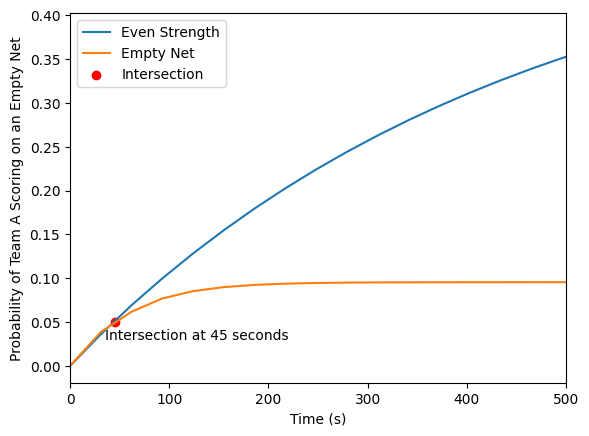

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(list(val_counts_even_strength.keys()))
y1 = np.array(list(val_counts_even_strength.values()))
y2 = np.array(list(val_counts_empty_net.values()))

plt.plot(x*31, y1, label='Even Strength')
plt.plot(x*31, y2, label='Empty Net')
plt.xlim(0, 500)
plt.xlabel('Time (s)')
plt.ylabel('Probability of Team A Scoring on an Empty Net')
plt.scatter(45, 0.05, color='red', label='Intersection')
plt.text(45-10, 0.05-0.02, 'Intersection at 45 seconds')
plt.legend()
plt.show()

## Second Test

Going from Team A shooting twice to Team A scoring.

In [ ]:
even_strength = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
             [0.037, 0.512, 0, 0, 0, 0.413, 0, 0, 0.033],
             [0.038, 0.509, 0, 0, 0, 0.432, 0, 0, 0.034],
             [0.036, 0, 0.499, 0, 0, 0.432, 0, 0, 0.033],
             [0.08, 0, 0, 0.42, 0, 0.42, 0, 0, 0.08],
             [0.033, 0, 0, 0.432, 0, 0, 0.499, 0, 0.0036],
             [0.034, 0, 0, 0.432, 0, 0, 0, 0.509, 0.038],
             [0.033, 0, 0, 0.413, 0, 0, 0, 0.517, 0.037],
             [0, 0, 0, 0, 0, 0, 0, 0, 1]])

t = 31

val_counts_even_strength = {}
for i in range(0, 20):
 val = np.linalg.matrix_power(even_strength, i)[2][0]
 val_counts_even_strength.update({i: val})
print(val_counts_even_strength)

{0: 0.0, 1: 0.038, 2: 0.071089, 3: 0.101716433, 4: 0.130213739054, 5: 0.156769848030143, 6: 0.18152724666119885, 7: 0.20461049147814753, 8: 0.22613330510162197, 9: 0.24620129947018618, 10: 0.26491284223635675, 11: 0.28235962619340066, 12: 0.29862714097097887, 13: 0.313795096496616, 14: 0.3279378146215394, 15: 0.3411245935445574, 16: 0.35342004742311395, 17: 0.36488442299007123, 18: 0.3755738947607769, 19: 0.3855408402843169}


In [ ]:
empty_net = np.array([[1, 0, 0, 0, 0],
              [0.061, 0.551, 0, 0, 0.387],
              [0.050, 0.535, 0, 0, 0.4155],
              [0.0386, 0, 0.464, 0, 0.497],
              [0, 0, 0, 0, 1]])

val_counts_empty_net = {}
for i in range(0, 20):
  val = np.linalg.matrix_power(empty_net, i)[2][0]
  val_counts_empty_net.update({i: val})
print(val_counts_empty_net)

{0: 0.0, 1: 0.05, 2: 0.082635, 3: 0.100616885, 4: 0.110524903635, 5: 0.11598422190288502, 6: 0.11899230626848964, 7: 0.1206497607539378, 8: 0.12156301817541973, 9: 0.12206622301465628, 10: 0.12234348888107562, 11: 0.12249626237347266, 12: 0.12258044056778344, 13: 0.1226268227528487, 14: 0.12265237933681962, 15: 0.12266646101458761, 16: 0.12267422001903779, 17: 0.12267849523048983, 18: 0.1226808508719999, 19: 0.12268214883047195}


In [ ]:
tolerance = 0.000000000000001
intersect_points = []

for key in val_counts_empty_net:
    if abs(val_counts_empty_net[key] - val_counts_even_strength.get(key, 0)) < tolerance:
        intersect_points.append((key, val_counts_empty_net[key]))

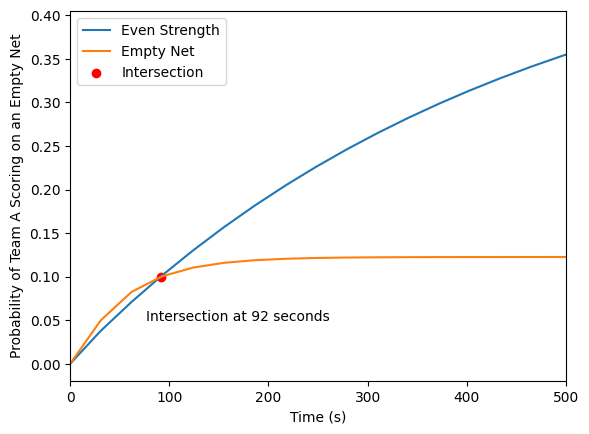

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(list(val_counts_even_strength.keys()))
y1 = np.array(list(val_counts_even_strength.values()))
y2 = np.array(list(val_counts_empty_net.values()))

plt.plot(x*31, y1, label='Even Strength')
plt.plot(x*31, y2, label='Empty Net')
plt.xlim(0, 500)
plt.xlabel('Time (s)')
plt.ylabel('Probability of Team A Scoring on an Empty Net')
plt.scatter(92, 0.1, color='red', label='Intersection')
plt.text(92-15, 0.1-.05, 'Intersection at 92 seconds')
plt.legend()
plt.show()

## Third Test

Going from Team A shooting three or more times to Team A scoring.

In [ ]:
even_strength = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
             [0.037, 0.512, 0, 0, 0, 0.413, 0, 0, 0.033],
             [0.038, 0.509, 0, 0, 0, 0.432, 0, 0, 0.034],
             [0.036, 0, 0.499, 0, 0, 0.432, 0, 0, 0.033],
             [0.08, 0, 0, 0.42, 0, 0.42, 0, 0, 0.08],
             [0.033, 0, 0, 0.432, 0, 0, 0.499, 0, 0.0036],
             [0.034, 0, 0, 0.432, 0, 0, 0, 0.509, 0.038],
             [0.033, 0, 0, 0.413, 0, 0, 0, 0.517, 0.037],
             [0, 0, 0, 0, 0, 0, 0, 0, 1]])

t = 31

val_counts_even_strength = {}
for i in range(0, 20):
 val = np.linalg.matrix_power(even_strength, i)[1][0]
 val_counts_even_strength.update({i: val})
print(val_counts_even_strength)

{0: 0.0, 1: 0.037, 2: 0.069573, 3: 0.09968030999999998, 4: 0.12768858377099998, 5: 0.15378774984876298, 6: 0.1781188498233021, 7: 0.200804542607609, 8: 0.22195666302256367, 9: 0.2416790171401744, 10: 0.2600682815384065, 11: 0.2772145705127458, 12: 0.29320190142552666, 13: 0.30810861135656525, 14: 0.32200774208204447, 15: 0.33496739824378696, 16: 0.347051081116402, 17: 0.3583179997719977, 18: 0.3688233612030101, 19: 0.37861864083272295}


In [ ]:
empty_net = np.array([[1, 0, 0, 0, 0],
              [0.061, 0.551, 0, 0, 0.387],
              [0.050, 0.535, 0, 0, 0.4155],
              [0.0386, 0, 0.464, 0, 0.497],
              [0, 0, 0, 0, 1]])

val_counts_empty_net = {}
for i in range(0, 20):
  val = np.linalg.matrix_power(empty_net, i)[1][0]
  val_counts_empty_net.update({i: val})
print(val_counts_empty_net)

{0: 0.0, 1: 0.061, 2: 0.094611, 3: 0.11313066100000001, 4: 0.12333499421100001, 5: 0.128957581810261, 6: 0.13205562757745382, 7: 0.13376265079517707, 8: 0.13470322058814257, 9: 0.13522147454406655, 10: 0.13550703247378068, 11: 0.13566437489305316, 12: 0.1357510705660723, 13: 0.13579883988190586, 14: 0.13582516077493012, 15: 0.13583966358698651, 16: 0.1358476546364296, 17: 0.1358520577046727, 18: 0.13585448379527468, 19: 0.13585582057119636}


In [ ]:
tolerance = 0.000000000000001
intersect_points = []

for key in val_counts_empty_net:
    if abs(val_counts_empty_net[key] - val_counts_even_strength.get(key, 0)) < tolerance:
        intersect_points.append((key, val_counts_empty_net[key]))

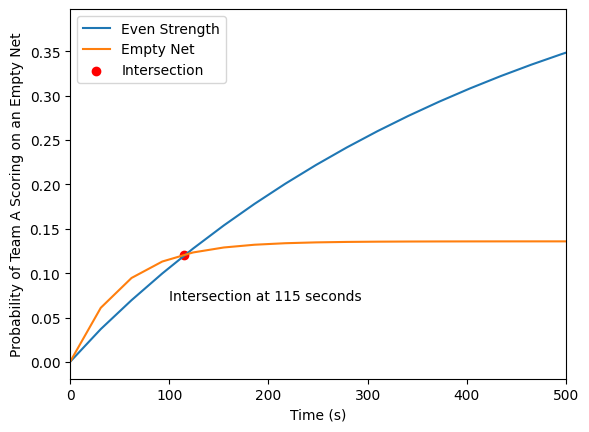

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(list(val_counts_even_strength.keys()))
y1 = np.array(list(val_counts_even_strength.values()))
y2 = np.array(list(val_counts_empty_net.values()))

plt.plot(x*31, y1, label='Even Strength')
plt.plot(x*31, y2, label='Empty Net')
plt.xlim(0, 500)
plt.xlabel('Time (s)')
plt.ylabel('Probability of Team A Scoring on an Empty Net')
plt.scatter(115, 0.12, color='red', label='Intersection')
plt.text(115-15, 0.12-.05, 'Intersection at 115 seconds')
plt.legend()
plt.show()

## Fourth Test

The probability form the even strength matrix that Team A will score from a neutral position after 465 seconds. (t=15)

In [ ]:
even_strength = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
             [0.037, 0.512, 0, 0, 0, 0.413, 0, 0, 0.033],
             [0.038, 0.509, 0, 0, 0, 0.432, 0, 0, 0.034],
             [0.036, 0, 0.499, 0, 0, 0.432, 0, 0, 0.033],
             [0.08, 0, 0, 0.42, 0, 0.42, 0, 0, 0.08],
             [0.033, 0, 0, 0.432, 0, 0, 0.499, 0, 0.0036],
             [0.034, 0, 0, 0.432, 0, 0, 0, 0.509, 0.038],
             [0.033, 0, 0, 0.413, 0, 0, 0, 0.517, 0.037],
             [0, 0, 0, 0, 0, 0, 0, 0, 1]])

val_counts_even_strength = {}
for i in range(0, 20):
 val = np.linalg.matrix_power(even_strength, i)[1][0]
 val_counts_even_strength.update({i: val})
print(val_counts_even_strength)

{0: 0.0, 1: 0.037, 2: 0.069573, 3: 0.09968030999999998, 4: 0.12768858377099998, 5: 0.15378774984876298, 6: 0.1781188498233021, 7: 0.200804542607609, 8: 0.22195666302256367, 9: 0.2416790171401744, 10: 0.2600682815384065, 11: 0.2772145705127458, 12: 0.29320190142552666, 13: 0.30810861135656525, 14: 0.32200774208204447, 15: 0.33496739824378696, 16: 0.347051081116402, 17: 0.3583179997719977, 18: 0.3688233612030101, 19: 0.37861864083272295}


In [ ]:
val_counts_even_strength[15]

0.33496739824378696